In [163]:
import numpy as np
import pandas as pd

import re
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn import preprocessing
from sklearn import metrics
from sklearn import ensemble
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline

In [164]:
# !pip install category_encoders

In [165]:
# Зафиксируем RANDOM_SEED
RANDOM_SEED = 42

In [166]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [167]:
# Прочитаем данные
df_test = pd.read_csv('/content/drive/MyDrive/hotels_data/hotels_test.csv')
df_train = pd.read_csv('/content/drive/MyDrive/hotels_data/hotels_train.csv')

Проект является переработкой задачи соревнования на платформе [kaggle](https://www.kaggle.com/code/dmitriyvishnyakov/eda-project-hotels-rating) о предсказании рейтинга отлелей компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.

Целью является сравнение двух типов моделей RandomForestRegressor и GragientBoostingRegressor

В датафрейме представлены следующие признаки:

+ hotel_address — адрес отеля;
+ review_date — дата, когда рецензент разместил соответствующий отзыв;
+ average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
+ hotel_name — название отеля;
+ reviewer_nationality — страна рецензента;
+ negative_review — отрицательный отзыв, который рецензент дал отелю;
+ review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
+ positive_review — положительный отзыв, который рецензент дал отелю;
+ review_total_positive_word_counts — общее количество слов в положительном отзыве.
+ reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
+ total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
+ total_number_of_reviews — общее количество действительных отзывов об отеле;
+ tags — теги, которые рецензент дал отелю;
+ days_since_review — количество дней между датой проверки и датой очистки;
+ additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
+ lat — географическая широта отеля;
+ lng — географическая долгота отеля.

In [168]:
# Данные для оценки качества модели
df_test.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644


In [169]:
# Данные для обучения модели
df_train.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [170]:
# Посмотрим информацию по тестовым данным
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [171]:
# Посмотрим информацию по тренировочным данным
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [172]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

<ipython-input-172-8cf29663fe87>:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [173]:
# Посмотрим на первые 3 строки, получившегося датафрейма
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0


In [174]:
# Посмотрим информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# Анализ и создание признаков

## Признак "Адрес отеля"

In [175]:
# Посмотрим количество уникальных значений в признаке
print(f'Количество уникальных значений в признаке hotel_address: {data["hotel_address"].nunique()}')

Количество уникальных значений в признаке hotel_address: 1493


В датасете 1493 уникальных названия отеля. В названии содержится информация от стране и городе. Выделим информацию о странах и создадим новый признак, который указывает на расположение отеля в столице страны.

In [176]:
# Добавим информацию о странах и столицах Европы из внешнего источника
# Адрес источника
url = 'https://www.careerpower.in/european-countries-name-and-capital-list.html'
# Прочитаем данные
df = pd.read_html(url)
country_data = df[0]
country_data = country_data.drop(country_data[0:1], axis=0)
country_data = country_data.rename(columns={0 : 'country', 1 : 'capital'})
country = list(country_data['country']) # Список стран Европы
capital = list(country_data['capital']) # Список столиц Европы
print(country, capital, sep='\n')

['Denmark', 'Sweden', 'Finland', 'Norway', 'Iceland', 'Kosovo', 'Slovenia', 'Albania', 'Croatia', 'North Macedonia', 'Bulgaria', 'Bosnia and Herzegovina', 'Montenegro', 'Serbia', 'Andorra', 'Austria', 'Germany', 'Belgium', 'France', 'Italy', 'Greece', 'Ireland', 'Malta', 'Liechtenstein', 'Luxembourg', 'Portugal', 'Monaco', 'Netherlands', 'Switzerland', 'San Marino', 'Spain', 'United Kingdom', 'Turkey', 'Azerbaijan', 'Belarus', 'Serbia', 'Slovakia', 'Ukraine', 'Poland', 'Republic of Moldova', 'Russia', 'Czech Republic', 'Estonia', 'Georgia', 'Hungary', 'Latvia', 'Lithuania', 'Armenia']
['Copenhagen', 'Stockholm', 'Helsinki', 'Oslo', 'Reykjavik', 'Pristina', 'Ljubljana', 'Tirana', 'Zagreb', 'Skopje', 'Sofia', 'Sarajevo', 'Podgorica', 'Belgrade', 'Andorra la Vella', 'Vienna', 'Berlin', 'Brussels', 'Paris', 'Rome', 'Athens', 'Dublin', 'Valletta', 'Vaduz', 'Luxembourg', 'Lisbon', 'No official capital', 'Amsterdam', 'Bern', 'San Marino', 'Madrid', 'London', 'Ankara', 'Baku', 'Minsk', 'Belgra

In [177]:
# Функция get_country возвращает название страны
def get_country(address):
    for item in address.split():
        if item in country: return item
        elif item == 'United': return 'United Kingdom'

# Функция get_in_capital возвращает 1, если отель находится в столице и 0, если нет
def get_in_capital(address):
    for item in address.split():
        if item in capital: return 1
    return 0

# Добавим признак 'country'
data['country'] = data['hotel_address'].apply(get_country)
# Добавим признак 'in_capital'
data['in_capital'] = data['hotel_address'].apply(get_in_capital)

In [178]:
# Посмотрим на количество отзывов, по получившимся признакам
# Создадим датафреймы, посчитав количество значений, и переименуем столбцы
data_country = data['country'].value_counts().reset_index().rename(columns={'index' : 'country', 'country' : 'count'})
data_in_capital = data['in_capital'].value_counts().reset_index().rename(columns={'index' : 'capital_code', 'in_capital' : 'count'})
display(data_country, data_in_capital)

,country,count
0,United Kingdom,262301
1,Spain,60149
2,France,59928
3,Netherlands,57214
4,Austria,38939
5,Italy,37207


,capital_code,count
0,1,418830
1,0,96908


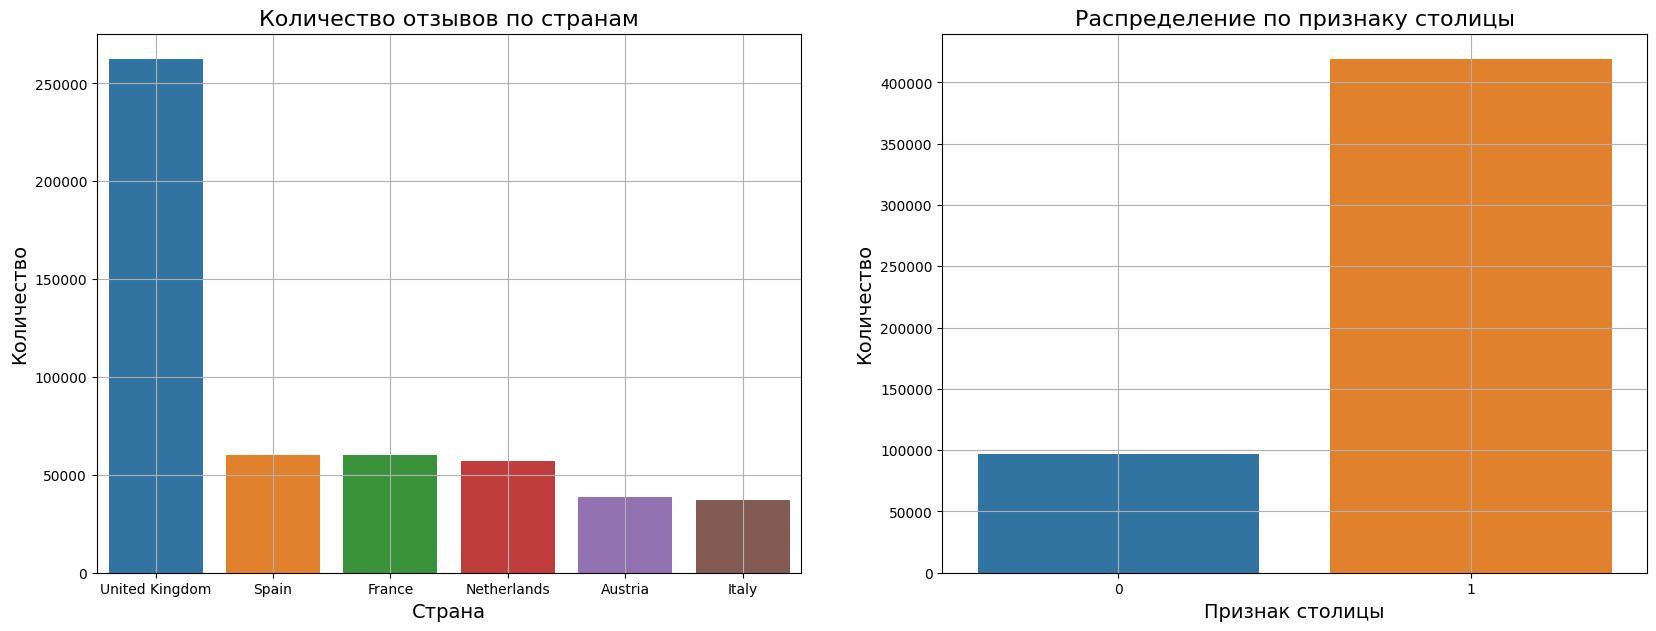

In [179]:
# Создадим две столбчатые диаграммы на одном поле
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

# График признака 'country'
barplot1 = sns.barplot(
    data_country,
    x='country',
    y='count',
    ax=axes[0]
)

# График признака 'in_capital'
barplot2 = sns.barplot(
    data_in_capital,
    x='capital_code',
    y='count',
    ax=axes[1]
)

barplot1.set_title('Количество отзывов по странам', fontsize=16);
barplot2.set_title('Распределение по признаку столицы', fontsize=16);
barplot1.set_xlabel('Страна', fontsize=14);
barplot1.set_ylabel('Количество', fontsize=14);
barplot2.set_xlabel('Признак столицы', fontsize=14);
barplot2.set_ylabel('Количество', fontsize=14);
barplot1.grid()
barplot2.grid()

Представлены отели из Великобритании, Испании, Франции, Нидерландов, Австрии и Италии.

Значительная часть отелей в датасете расположена в Великобритании. По остальным странам отели распределены примерно одинаково.

По признаку столицы также наблюдается несбалансированность. Большая часть отелей находится в столицах стран. Это связано с тем, что столицы в этих странах, с одной стороны, являются туристическими центрами, а, с другой, пунктами, куда турист приезжает в первую очередь.


## Признак "Дата отзыва"

In [180]:
# Преобразуем признак 'review_date' в тип данных datetime
data['review_date'] = pd.to_datetime(data['review_date'])

In [181]:
# Посмотрим на временные границы отзывов
print(f'Дата первого отзыва: {data["review_date"].min()}')
print(f'Дата последнего отзыва: {data["review_date"].max()}')

Дата первого отзыва: 2015-08-04 00:00:00
Дата последнего отзыва: 2017-08-03 00:00:00


В датасете представлены данные об отзывах с 4 августа 2015 года по 3 августа 2017 года.

In [182]:
# Создадим признак месяц отзыва
data['review_month'] = data['review_date'].apply(lambda date: date.month)

In [183]:
# Посмотрим на количество отзывов относительно месяца
data_month = data['review_month'].value_counts().reset_index().rename(columns={'index' : 'month number', 'review_month' : 'count'})
display(data_month)

,month number,count
0,8,50672
1,7,49318
2,5,46490
3,10,43843
4,6,42896
5,4,42883
6,9,42428
7,1,42151
8,3,41110
9,12,39607


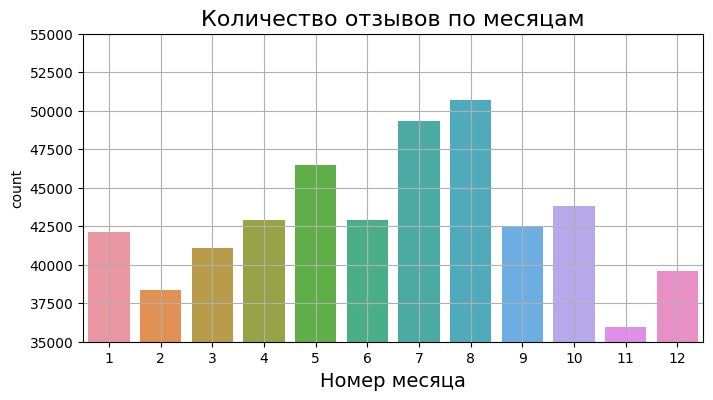

In [184]:
# Построим для признака 'review_month' столбчатую диаграмму
fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(
                 data_month,
                 x='month number',
                 y='count'
    )

ax.set_title('Количество отзывов по месяцам', fontsize=16);
ax.set_xlabel('Номер месяца', fontsize=14);
ax.set_ylim(35000, 55000)
ax.grid()

Создадим признак "Сезон"
- 1 - Зима
- 2 - Весна
- 3 - Лето
- 4 - Осень

In [185]:
# Функция get_season возвращает номер сезона
def get_season(month):
    if month in [12, 1, 2]: return 1 # Зима
    elif month in [3, 4, 5]: return 2 # Весна
    elif month in [6, 7, 8]: return 3 # Лето
    else:
        return 4 # Осень

# Создадаим признак 'season'
data['season'] = data['review_month'].apply(get_season)

In [186]:
# Посмотрим на количество отзывов по сезонам
data_season = data['season'].value_counts().reset_index().rename(columns={'index' : 'season number', 'season' : 'count'})
display(data_season)

,season number,count
0,3,142886
1,2,130483
2,4,122241
3,1,120128


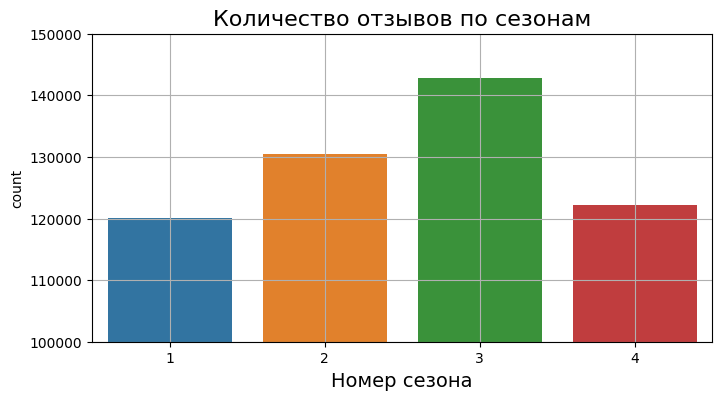

In [187]:
# Построим столбчатую диаграмму для признака
fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(
                 data_season,
                 x='season number',
                 y='count'
    )

ax.set_title('Количество отзывов по сезонам', fontsize=16);
ax.set_xlabel('Номер сезона', fontsize=14);
ax.set_ylim(100000, 150000)
ax.grid()

## Признак "Название отеля"

In [188]:
# Посмотрим на количество уникальных названий отелей
print(f'Количество отелей в датасете: {data["hotel_name"].nunique()}')

Количество отелей в датасете: 1492


Уникальных значений в признаке слишком много. Можно сократить их количество до 20 отелей, которые чаще всего упоминаются

In [189]:
# Создадим список из Топ-20 отелей
top_20_hotels = list(data['hotel_name'].value_counts().nlargest(20).index)

# Заменим название отелей, не вошедших в Топ-5 на 'Other'
data['hotel_name'] = data['hotel_name'].apply(lambda name: name if name in top_20_hotels else 'Other')
display(data['hotel_name'].value_counts())

Other                                                460873
Britannia International Hotel Canary Wharf             4789
Strand Palace Hotel                                    4256
Park Plaza Westminster Bridge London                   4169
Copthorne Tara Hotel London Kensington                 3578
DoubleTree by Hilton Hotel London Tower of London      3212
Grand Royale London Hyde Park                          2958
Holiday Inn London Kensington                          2768
Hilton London Metropole                                2628
Millennium Gloucester Hotel London                     2565
Intercontinental London The O2                         2551
Park Grand Paddington Court                            2288
Hilton London Wembley                                  2227
Park Plaza County Hall London                          2223
Blakemore Hyde Park                                    2178
Park Plaza London Riverbank                            2167
M by Montcalm Shoreditch London Tech Cit

## Признак "Негативные отзывы"

В признаке "Негативные озывы" большая часть ими не является, вместо этого указано на отсутствие негативного отзыва множеством вариантов. Их мы приведем к одной категории "Not negative". Остальные отзывы разделим на категории по наиболее частым причинам недовольства постояльцев: Room, Parking, Location, Price, Breakfast, Staff. Все остальные отзывы отнесем к категории Service.

In [190]:
# Функция возвращет категории, по которым разделяются негативные признаки:
# комната, парковка, местоположение отеля, цена, завтрак, персонал
# в категорию "сервис", вошли все оставшиеся отзывы
def neg_category(review):
#     Список значений, которые не являются негативными
    no_negativ_list = ['No Negative', 'Nothing', 'None', 'N A', '', 'Nothing really', 'N a',
                   'All good', 'No complaints', 'Nothing at all', 'Nothing to dislike',
                   'none', 'Nil', 'Everything was perfect', 'n a', 'Can t think of anything',
                   'Absolutely nothing', 'Everything was great', 'Nothing to complain about',
                   'Nothing not to like', 'Everything was good', 'NA', 'NOTHING', 'Having to leave',
                   'I liked everything', 'Liked everything', 'No', 'Nothing all good',
                   'Everything was fine', 'All was good', 'Na', 'Nothing in particular',
                   'Nothing it was perfect', 'Nothing it was perfect', 'Non', 'No complaints at all',
                   'nothing', 'There was nothing I didn t like', 'Not applicable', 'Nothing comes to mind',
                   'Nothing everything was great', 'Nothing everything was perfect', 'No negatives',
                   'Nothing to report', 'There was nothing to dislike', 'Not a thing', 'We liked everything',
                   'It was all good', 'Nothing I didn t like', 'nothing really', 'Loved everything',
                   'There was nothing we didn t like', 'No thing', 'Nothing to mention', 'no complaints',
                   'No problems', 'Nothing I can think of', 'No issues', 'There was nothing not to like',
                   'No comment', 'Nothing to say', 'no', 'No bad experience', 'All ok', 'all good',
                   'Nothing bad to say', 'Nothing to complain']
#     Словарь категорий признаков
    neg_category_dict = {'Room' : ['room', 'Room', 'bathroom', 'Bathroom'],
                     'Parking' : ['parking', 'Parking'],
                     'Location' : ['location', 'Location'],
                     'Price' : ['price', 'Price', 'Coast'],
                     'Breakfast' : ['breakfast', 'Breakfast'],
                     'Staff' : ['staff', 'Staff']
    }
    if review in no_negativ_list:
        return 'Not negative' # Возвращается 'Not negative', если отзыв не является негативным
    else:
        splitted = review.split()
        for arg in splitted:
            for key, value in neg_category_dict.items():
                if arg in value:
                    return key
        return 'Service'

# Вносим изменения в признак
data['negative_review'] = data['negative_review'].apply(neg_category)

In [191]:
# Посмотрим на количество негативных отзывов по категориям
data['negative_review'].value_counts()

Service         188138
Not negative    127890
Room            120799
Breakfast        36091
Staff            22451
Location          7703
Price             6968
Parking           5698
Name: negative_review, dtype: int64

## Признак "Позитивные отзывы"

Объединим не позитивные отзывы в категорию 'Not positive'. Остальные отзывы разделим на категории по наиболее частым причинам недовольства постояльцев: Room, Parking, Location, Price, Breakfast, Staff. Все остальные отзывы отнесем к категории Service.

In [192]:
# Функция возвращет категории, по которым разделяются позитивные отзывы:
# комната, парковка, местоположение отеля, цена, завтрак, персонал
# в категорию "сервис", вошли все оставшиеся отзывы
def pos_category(review):
    no_positive_list = ['No Positive', 'Nothing', 'nothing'] # Список не позитивных отзывов
    # Словарь для распределения на категории
    pos_category_dict = {'Room' : ['room', 'Room', 'bathroom', 'Bathroom'],
                     'Parking' : ['parking', 'Parking'],
                     'Location' : ['location', 'Location', 'Position'],
                     'Price' : ['price', 'Price', 'Coast'],
                     'Breakfast' : ['breakfast', 'Breakfast'],
                     'Staff' : ['staff', 'Staff']
    }
    if review in no_positive_list:
        return 'Not positive'
    else:
        splitted = review.split()
        for arg in splitted:
            for key, value in pos_category_dict.items():
                if arg in value:
                    return key
        return 'Service'

# Вносим изменения в признак
data['positive_review'] = data['positive_review'].apply(pos_category)

Посмотрим на графике на распределение негативных и позитивных отзывов по категориям.

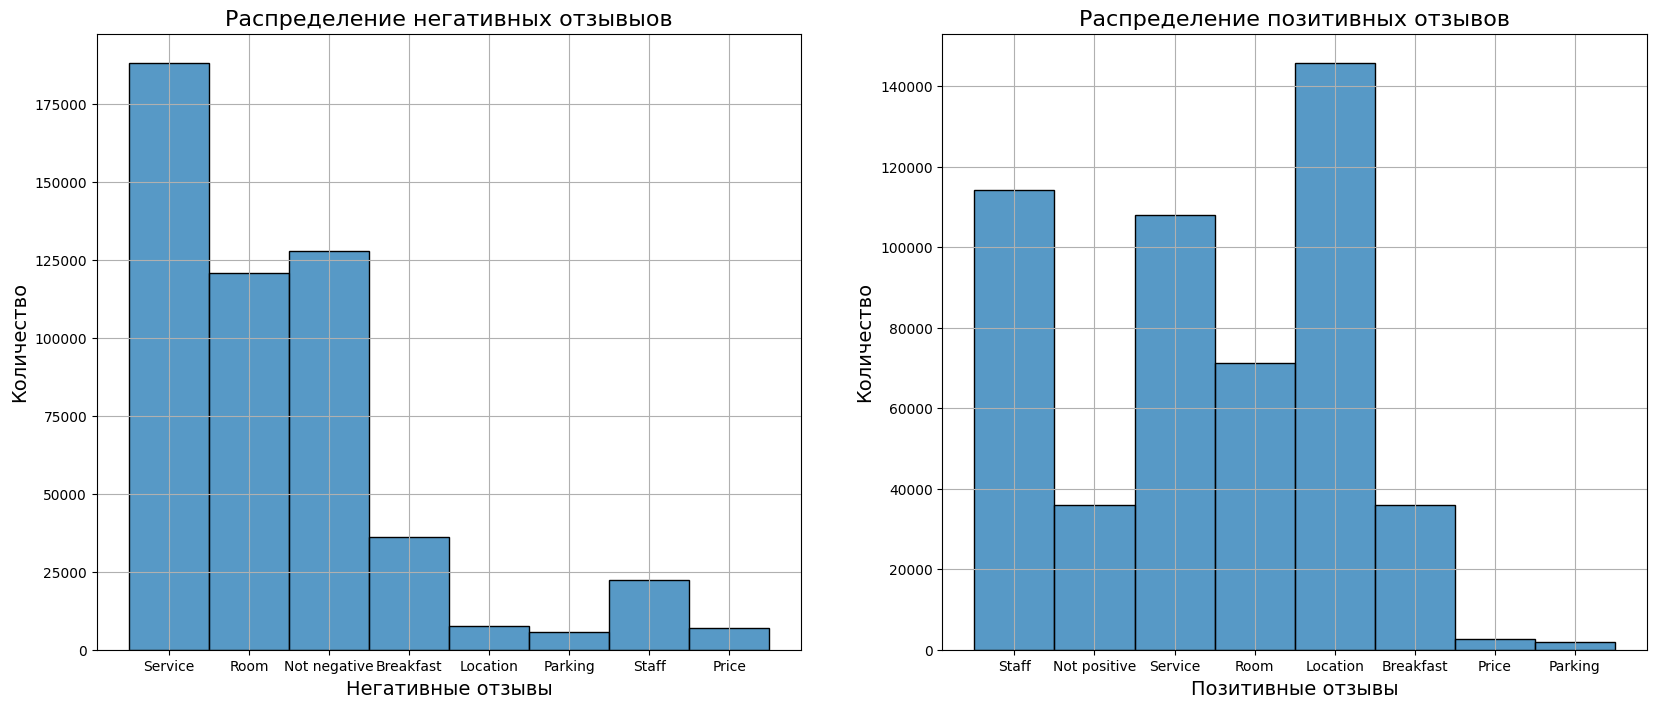

In [193]:
# Создадим две столбчатые диаграммы на одном поле
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# График признака 'Негативные отзывы'
histplot1 = sns.histplot(
    data,
    x='negative_review',
    ax=axes[0]
)

# График признака 'Позитивные отзывы'
histplot2 = sns.histplot(
    data,
    x='positive_review',
    ax=axes[1]
)

histplot1.set_title('Распределение негативных отзывыов', fontsize=16);
histplot2.set_title('Распределение позитивных отзывов', fontsize=16);
histplot1.set_xlabel('Негативные отзывы', fontsize=14);
histplot1.set_ylabel('Количество', fontsize=14);
histplot2.set_xlabel('Позитивные отзывы', fontsize=14);
histplot2.set_ylabel('Количество', fontsize=14);
histplot1.grid()
histplot2.grid()

В числе негативных отзывов самое большое количество имеет категория Service, в которую попали отзывы, не вошедшие в основные категории. Таким образом большинство претензий постояльцев отелей относится к различным вопросам, чуть меньше к комнате и удобствам в ней. Низкие значения показывют завтрак и проблемы с персоналом. Незначительное количество негативных отзывов связано с ценой и парковкой.

По позитивным отзывам ситуация отличается. Большее внимание гостей отелей привлекло их расположение и, видимо, удобство перемещения к достопримечательностям и другим локациям. Благодарность персоналу также имеет большое значение среди отзывов. Возросли положительные отзывы по завтраку и прочим вопросам. Цена и парковка также не оказали большого влияния на положительные отзывы.

## Признак "Национальность гостя"

In [194]:
# Посмотрим на количество отзывов по гражданству гостей
data['reviewer_nationality'].value_counts()

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
                               ...  
 Comoros                           1
 Anguilla                          1
 Tuvalu                            1
 Cape Verde                        1
 Palau                             1
Name: reviewer_nationality, Length: 227, dtype: int64

В признаке представлены 227 стран, гости из которых оставили отзывы об отелях. Выделим 10 стран, гости из которых, наиболее активно оставляли отзывы об отелях.

In [195]:
# Уберем пробелы в начале и в конце строк
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())

In [196]:
# Создадим список Топ-10 стран по количеству отзывов
top_10_reviewer_nationality = list(data['reviewer_nationality'].value_counts().nlargest(10).index)
print(top_10_reviewer_nationality)

['United Kingdom', 'United States of America', 'Australia', 'Ireland', 'United Arab Emirates', 'Saudi Arabia', 'Netherlands', 'Switzerland', 'Germany', 'Canada']


In [197]:
# Страны, которые не вошли в список Топ-10 включим в категорию 'Other'
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda nation: nation if nation in top_10_reviewer_nationality else 'Other')

In [198]:
# Посмотрим на распределение по категориям
data_nationality = data['reviewer_nationality'].value_counts().reset_index().rename(columns={'index' : 'nationality', 'reviewer_nationality' : 'count'})
data_nationality.sort_values(by='count', ascending=False)

,nationality,count
0,United Kingdom,245246
1,Other,146071
2,United States of America,35437
3,Australia,21686
4,Ireland,14827
5,United Arab Emirates,10235
6,Saudi Arabia,8951
7,Netherlands,8772
8,Switzerland,8678
9,Germany,7941


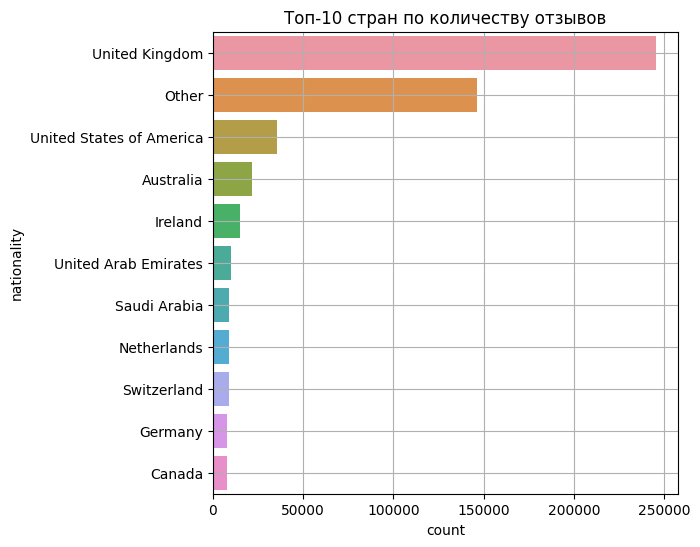

In [199]:
# Построим горизонтальную столбчатую диаграмму, чтобы посмотреть на распределение признака
ax = sns.barplot(data_nationality.sort_values(by='count', ascending=False),
            x='count',
            y='nationality',
            )

ax.set_title('Топ-10 стран по количеству отзывов');
ax.grid()

## Признак "Теги"

In [200]:
# Составим словарь из уникальных тегов и посчитаем их количество
tags_dict = {}
# Функция возвращает словарь, в котором ключом является уникальный тег,
# а значением количество его повторений
for tags_list in data['tags']:
    tags = ''.join(tags_list)
    tags = tags.replace("'", "")
    tags = tags.replace("[", "")
    tags = tags.replace("]", "")
    tags = tags.split(",")
    for tag in tags:
        tag = tag.strip()
        if tag in tags_dict:
            tags_dict[tag] += 1
        else:
            tags_dict[tag] = 1

# Посчитаем количество уникальных тегов
print(f'Количество уникальных тегов: {len(tags_dict)}')

Количество уникальных тегов: 2428


In [201]:
# Создадим признак "Тип поездки", в котором выделяются туристическая и деловая поездки,
# если тип поездки не указан, то заполняется 0
def type_trip(tags):
    if 'Leisure trip' in tags: return '1' # туристическая поездка
    elif 'Business trip' in tags: return '2' # деловая поездка
    return 0
# Вносим изменеия в признак
data['type_trip'] = data['tags'].apply(type_trip)

In [202]:
# Посмотрим на количество отзывов по типу поездки
data['type_trip'].value_counts()

1    417778
2     82939
0     15021
Name: type_trip, dtype: int64

In [203]:
# Создадим признак "Количество гостей"
def get_guests_count(tags):
    guest_list = ['Solo traveler', # одиночный путешественник
                  'Travelers with friends', # поездка с друзьями
                  'Couple', # пара
                  'Group', # групповая поездка
                  'Family with older children', # семья с детьми
                  'Family with young children'] # семья с маленькими детьми
    for tag in guest_list:
        if tag in tags: return tag
    return 0 # если отсутствует категория, то возвращется 0

# Вносим изменения в признак
data['guest_count'] = data['tags'].apply(get_guests_count)

In [204]:
# Посмотрим на количество отзывов относительно количества гостей
data['guest_count'].value_counts()

Couple                        252294
Solo traveler                 108545
Group                          65392
Family with young children     61015
Family with older children     26349
Travelers with friends          2143
Name: guest_count, dtype: int64

In [205]:
# Функция возвращает количество ночей, проведенных гостем в отеле
def count_nights(tags):
    result = re.findall(r'\d+ night', tags)
    for i in result:
        return i[:2]

# Создадим признак "Количество ночей"
data['count_nights'] = data['tags'].apply(count_nights)
# Заполним пропущенные значения 0
values = {'count_nights' : data['count_nights'].median()}
data['count_nights'] = data['count_nights'].fillna(0)

In [206]:
# Посмотрим на количество записей отностельно количества ночей, отсортируем по убыванию
data['count_nights'].value_counts().sort_values(ascending=False)

1     193644
2     133936
3      95825
4      47817
5      20843
6       9776
7       7399
8       2502
9       1293
10       889
11       418
12       316
14       247
13       246
0        192
15       117
16        57
17        42
18        33
19        29
21        23
20        19
27        11
30        11
23        10
22        10
25         7
26         7
28         7
24         6
29         5
31         1
Name: count_nights, dtype: int64

Наибольшее количество отзывов у гостей, которые проживали в отеле не больше 5 ночей

In [207]:
# Создадим признак "Стандартный номер"
data['standard_room'] = data['tags'].apply(lambda x: 1 if 'Standard' in x else 0)

In [208]:
# Посмотрим на количество отзывов гостей, проживавших в стандартном номере
data['standard_room'].value_counts()

0    428391
1     87347
Name: standard_room, dtype: int64

## Признак "Количество дней с момента отзыва"

In [209]:
# Уберем слово 'day' и переведем к числовому типу
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split()[0])
data['days_since_review'] = data['days_since_review'].astype('int')

In [210]:
# Посмотрим на количество отзывов
data['days_since_review'].value_counts()


1      2585
322    2308
120    2284
338    1963
534    1940
       ... 
327     199
615     194
122     192
124     173
123     143
Name: days_since_review, Length: 731, dtype: int64

# Очистка данных и преобразование признаков

## Пропущенные значения

Найдем столбцы с пропусками и посчитаем их процент от общего значения

In [211]:
# Посчитаем процент пропуска в столбцах
cols_null_percent = data.isnull().mean()*100
# Запишем столбцы с пропусками в переменную cols_with_nul
cols_with_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
display(cols_with_null)

lat    0.633655
lng    0.633655
dtype: float64

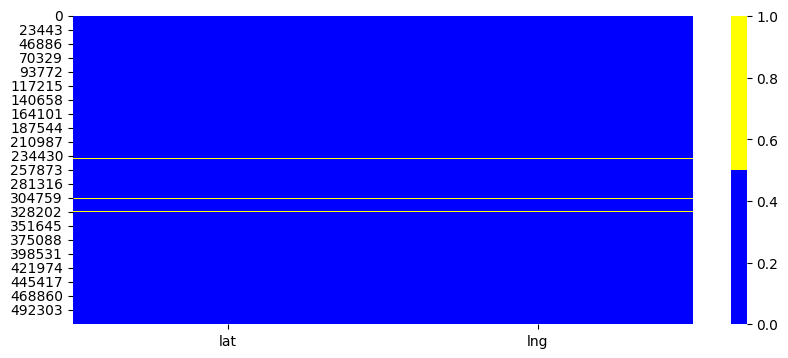

In [212]:
# Построим тепловую карту пропусков
colors = ['blue', 'yellow']
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
    data[cols].isnull(),
    cmap = sns.color_palette(colors),
)

Пропуски в одних и тех же значениях. Всего их 0.6% от общего числа данных. Так как координаты - это уникальные значения, заменим пропуски нулями.


In [213]:
data = data.fillna(0)
data.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
country                                       0
in_capital                                    0
review_month                            

## Удаление обработанных признаков

Удалим из датасета признаки, из которых уже получена необходимая информация. Это признаки: 'hotel_address', 'review_date', 'hotel_name', 'tags'

In [214]:
drop_list = ['hotel_address', 'review_date', 'tags']
data = data.drop(drop_list, axis=1)

In [215]:
# Выведем информацию об оставшихся признаках
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   reviewer_nationality                        515738 non-null  object 
 4   negative_review                             515738 non-null  object 
 5   review_total_negative_word_counts           515738 non-null  int64  
 6   total_number_of_reviews                     515738 non-null  int64  
 7   positive_review                             515738 non-null  object 
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

In [216]:
# Преобразуем признак "Количество ночей" и "Тип поездки" в числовой
data['count_nights'] = data['count_nights'].astype('int64')
data['type_trip'] = data['type_trip'].astype('int64')

## Кодирование категориальных признаков

In [217]:
# Создадим список колонок с категориальными признаками
category_list = [x for x in data.columns if data[x].dtypes == 'object']
category_list

['hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'country',
 'guest_count']

In [218]:
# Объединим категориальные признаки в датафрейм
category_data = data[category_list]
category_data

,hotel_name,reviewer_nationality,negative_review,positive_review,country,guest_count
0,Hotel Da Vinci,United Kingdom,Service,Staff,Italy,Couple
1,Other,Other,Room,Not positive,Netherlands,Group
2,Other,Other,Service,Service,Spain,Solo traveler
3,Other,United States of America,Not negative,Room,Italy,Couple
4,Other,United Kingdom,Not negative,Staff,Netherlands,Solo traveler
...,...,...,...,...,...,...
515733,Other,Other,Not negative,Service,United Kingdom,Group
515734,Other,Other,Not negative,Room,Austria,Couple
515735,Other,Netherlands,Room,Location,United Kingdom,Solo traveler
515736,Other,United Arab Emirates,Not negative,Location,United Kingdom,Solo traveler


In [219]:
# Для выбора способа кодирования посмотрим на количество категорий в признаках
for col in category_data.columns:
    print(f'В признаке {col} количество категорий: {category_data[col].nunique()}')

В признаке hotel_name количество категорий: 21
В признаке reviewer_nationality количество категорий: 11
В признаке negative_review количество категорий: 8
В признаке positive_review количество категорий: 8
В признаке country количество категорий: 6
В признаке guest_count количество категорий: 6


В признаке "hotel_name" 21 номинальная категория, поэтому для него воспользуемся бинарным кодированием

In [220]:
bin_encoder = ce.BinaryEncoder(cols=['hotel_name'])
type_bin = bin_encoder.fit_transform(data['hotel_name'])
data = pd.concat([data, type_bin], axis=1)


In [221]:
# Удалим признак "hotel_name"
data = data.drop("hotel_name", axis=1)

Для остальных признаков воспользуемся однократным кодированием

In [222]:
# Снова создаем список категориальных признаковдля кодирования без названия отеля
col_list = [x for x in data.columns if data[x].dtypes == 'object']
print(col_list)
# Кодируем признаки с помощью OneHotEncoder
onehot = ce.OneHotEncoder(cols=col_list, use_cat_names=True)
type_bin = onehot.fit_transform(data[col_list])
data = pd.concat([data, type_bin], axis=1)

['reviewer_nationality', 'negative_review', 'positive_review', 'country', 'guest_count']


In [223]:
# Удалим категориальные признаки
data = data.drop(col_list, axis=1)

In [224]:
# Посмотрим информацию о признаках
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 61 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   additional_number_of_scoring                   515738 non-null  int64  
 1   average_score                                  515738 non-null  float64
 2   review_total_negative_word_counts              515738 non-null  int64  
 3   total_number_of_reviews                        515738 non-null  int64  
 4   review_total_positive_word_counts              515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given     515738 non-null  int64  
 6   days_since_review                              515738 non-null  int64  
 7   lat                                            515738 non-null  float64
 8   lng                                            515738 non-null  float64
 9   sample                               

## Преобразование признаков

Сначала посмотрим на распределение некоторых признаков

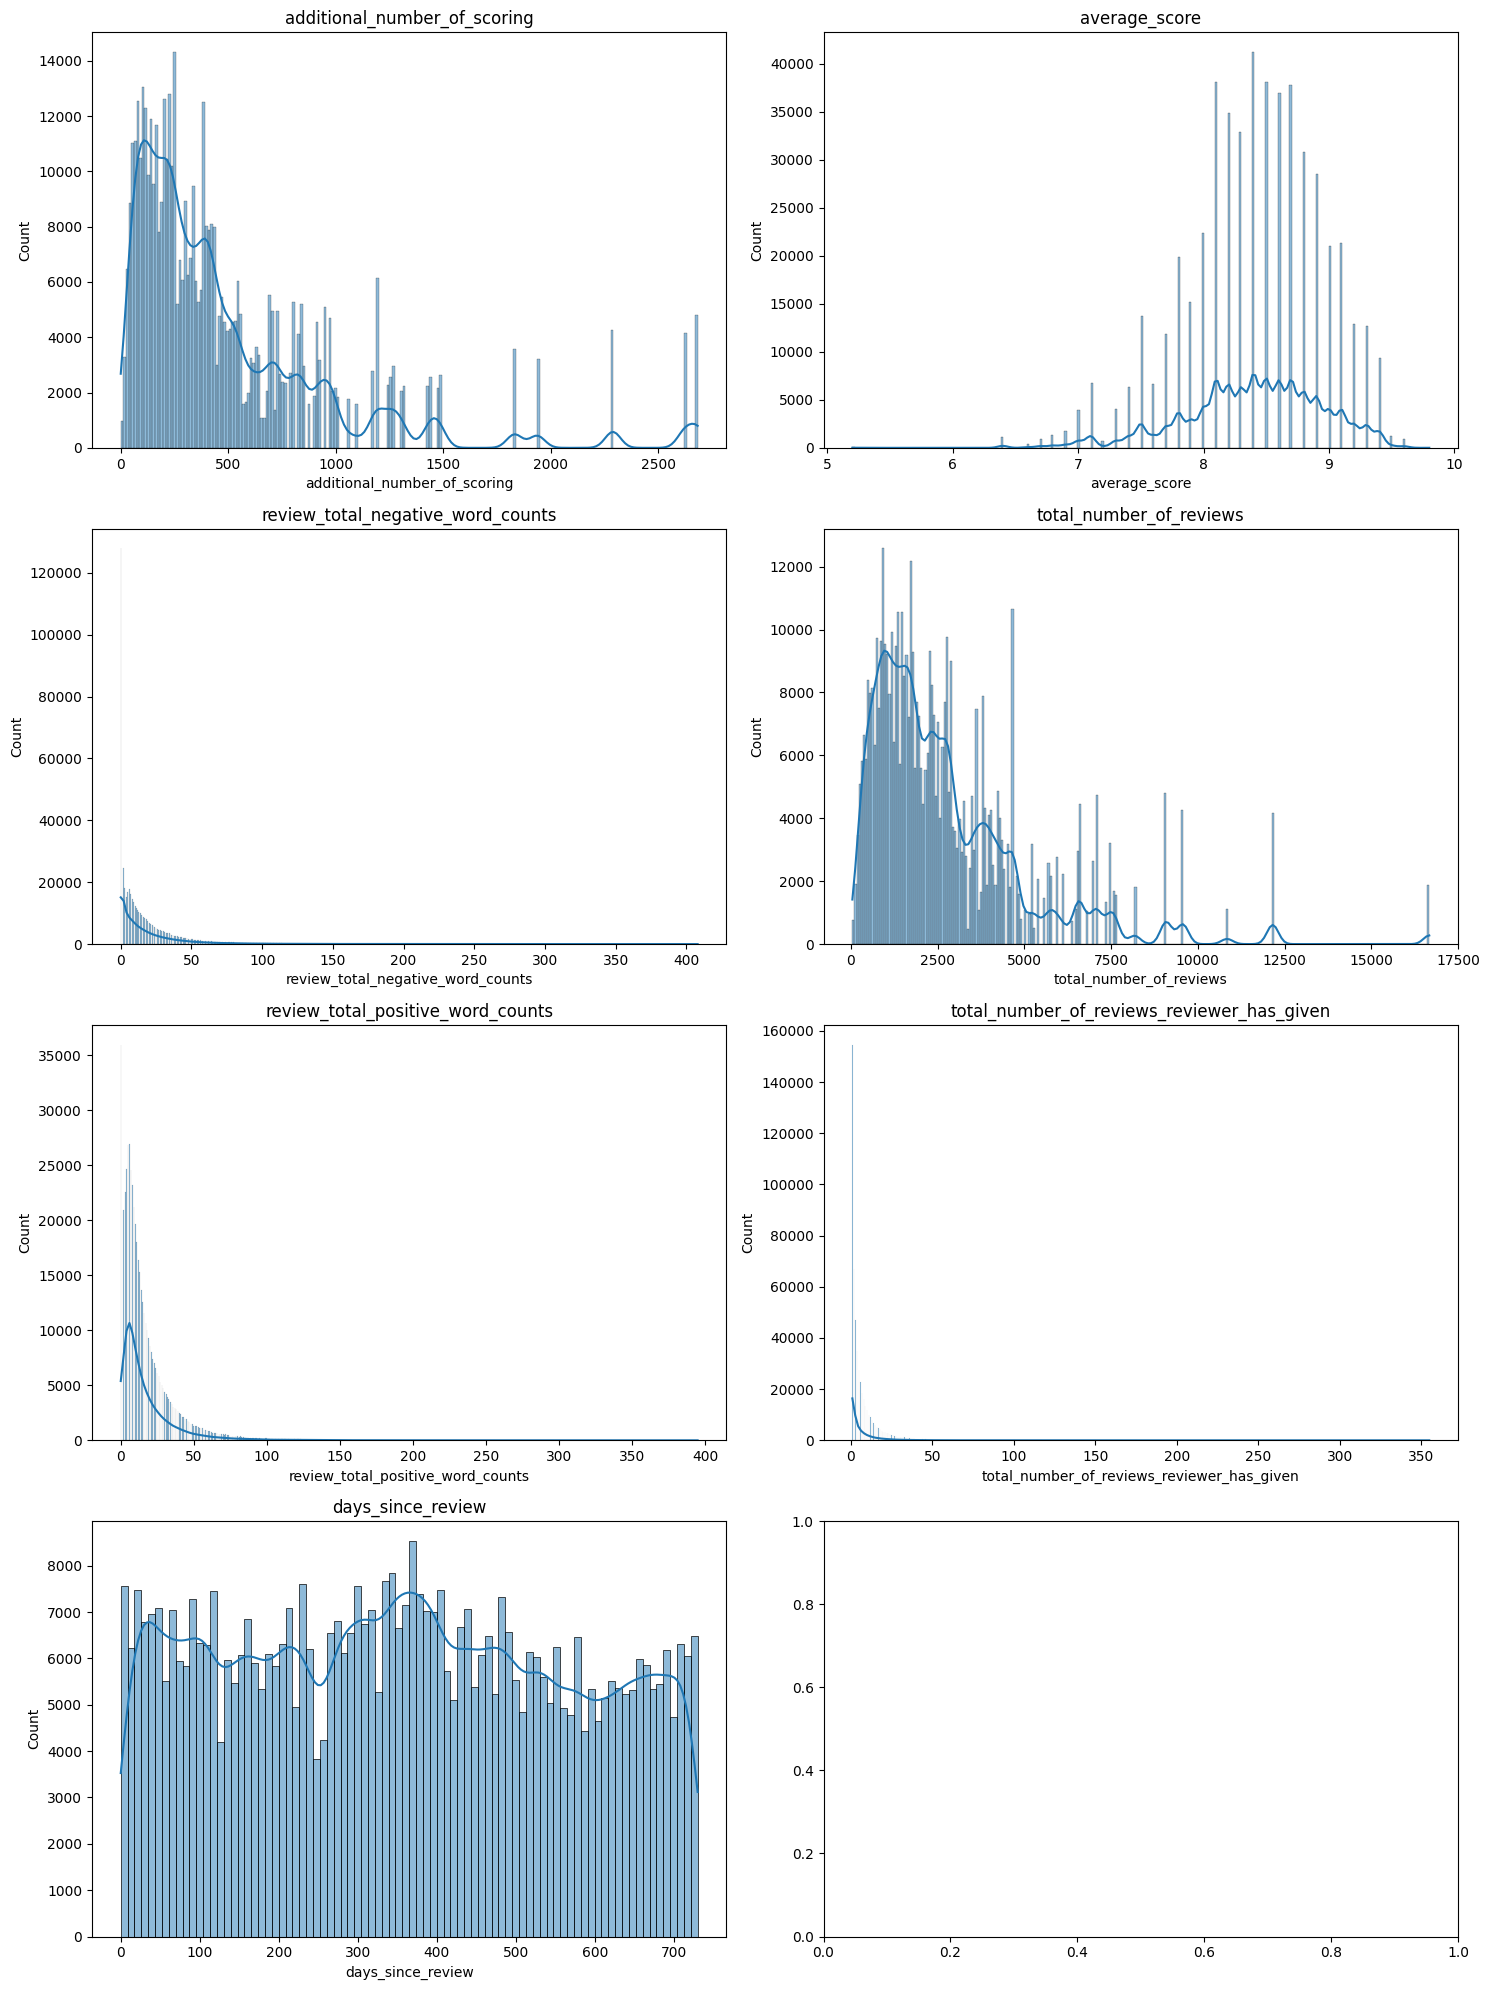

In [225]:
# Список признаков, которые будем нормализовать
cols = ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts',
        'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',
       'days_since_review']

# Построим гистограммы с графиком плотности ядра для каждого признака
try:
    plt.figure(figsize=(15, 20))
    for i, col in enumerate(data.columns):
        ax = plt.subplot(4, 2, i+1)
        sns.histplot(data, x=cols[i], kde=True)
        plt.title(data.columns[i])
        plt.tight_layout()
except: ValueError

plt.show()

Распределение приближено к нормальному в признаке "average_score". У остальных признаков, кроме "days_since_review" распеределение смещено к 0 значению.
Проведенм нормализацию этх признаков, используя MinMaxScaler

In [228]:
m_scaler = preprocessing.MinMaxScaler()
data[cols] = m_scaler.fit_transform(data[cols])

Посмотрим на то, как изменились распредедения после нормализации с помощью графика плотности ядра

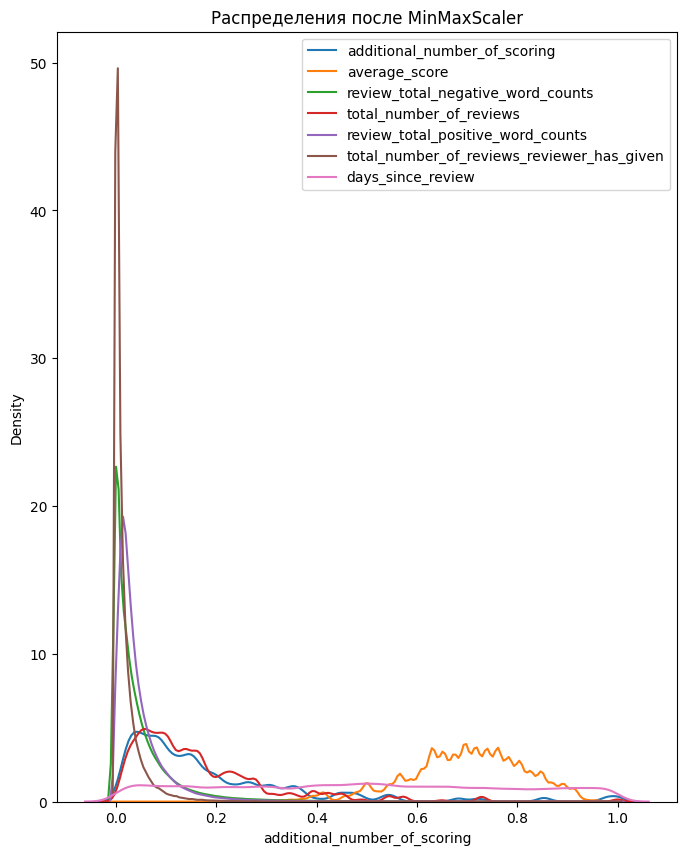

In [229]:
# Поле для графика
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 10))
# Название графика
ax1.set_title('Распределения после MinMaxScaler')
# Построим график плотности ядра для каждого признака
sns.kdeplot(data['additional_number_of_scoring'], ax=ax1, label='additional_number_of_scoring')
sns.kdeplot(data['average_score'], ax=ax1, label='average_score')
sns.kdeplot(data['review_total_negative_word_counts'], ax=ax1, label='review_total_negative_word_counts')
sns.kdeplot(data['total_number_of_reviews'], ax=ax1, label='total_number_of_reviews')
sns.kdeplot(data['review_total_positive_word_counts'], ax=ax1, label='review_total_positive_word_counts')
sns.kdeplot(data['total_number_of_reviews_reviewer_has_given'], ax=ax1, label='total_number_of_reviews_reviewer_has_given')
sns.kdeplot(data['days_since_review'], ax=ax1, label='days_since_review')
plt.legend()

Распределения большинства признаков смещены к отметке 0. Там же они имеют наибольшие значения.

# Отбор признаков и обучение модели

## Корреляция признаков

Посмотрим на корреляцию признаков, которые не были созданы кодированием

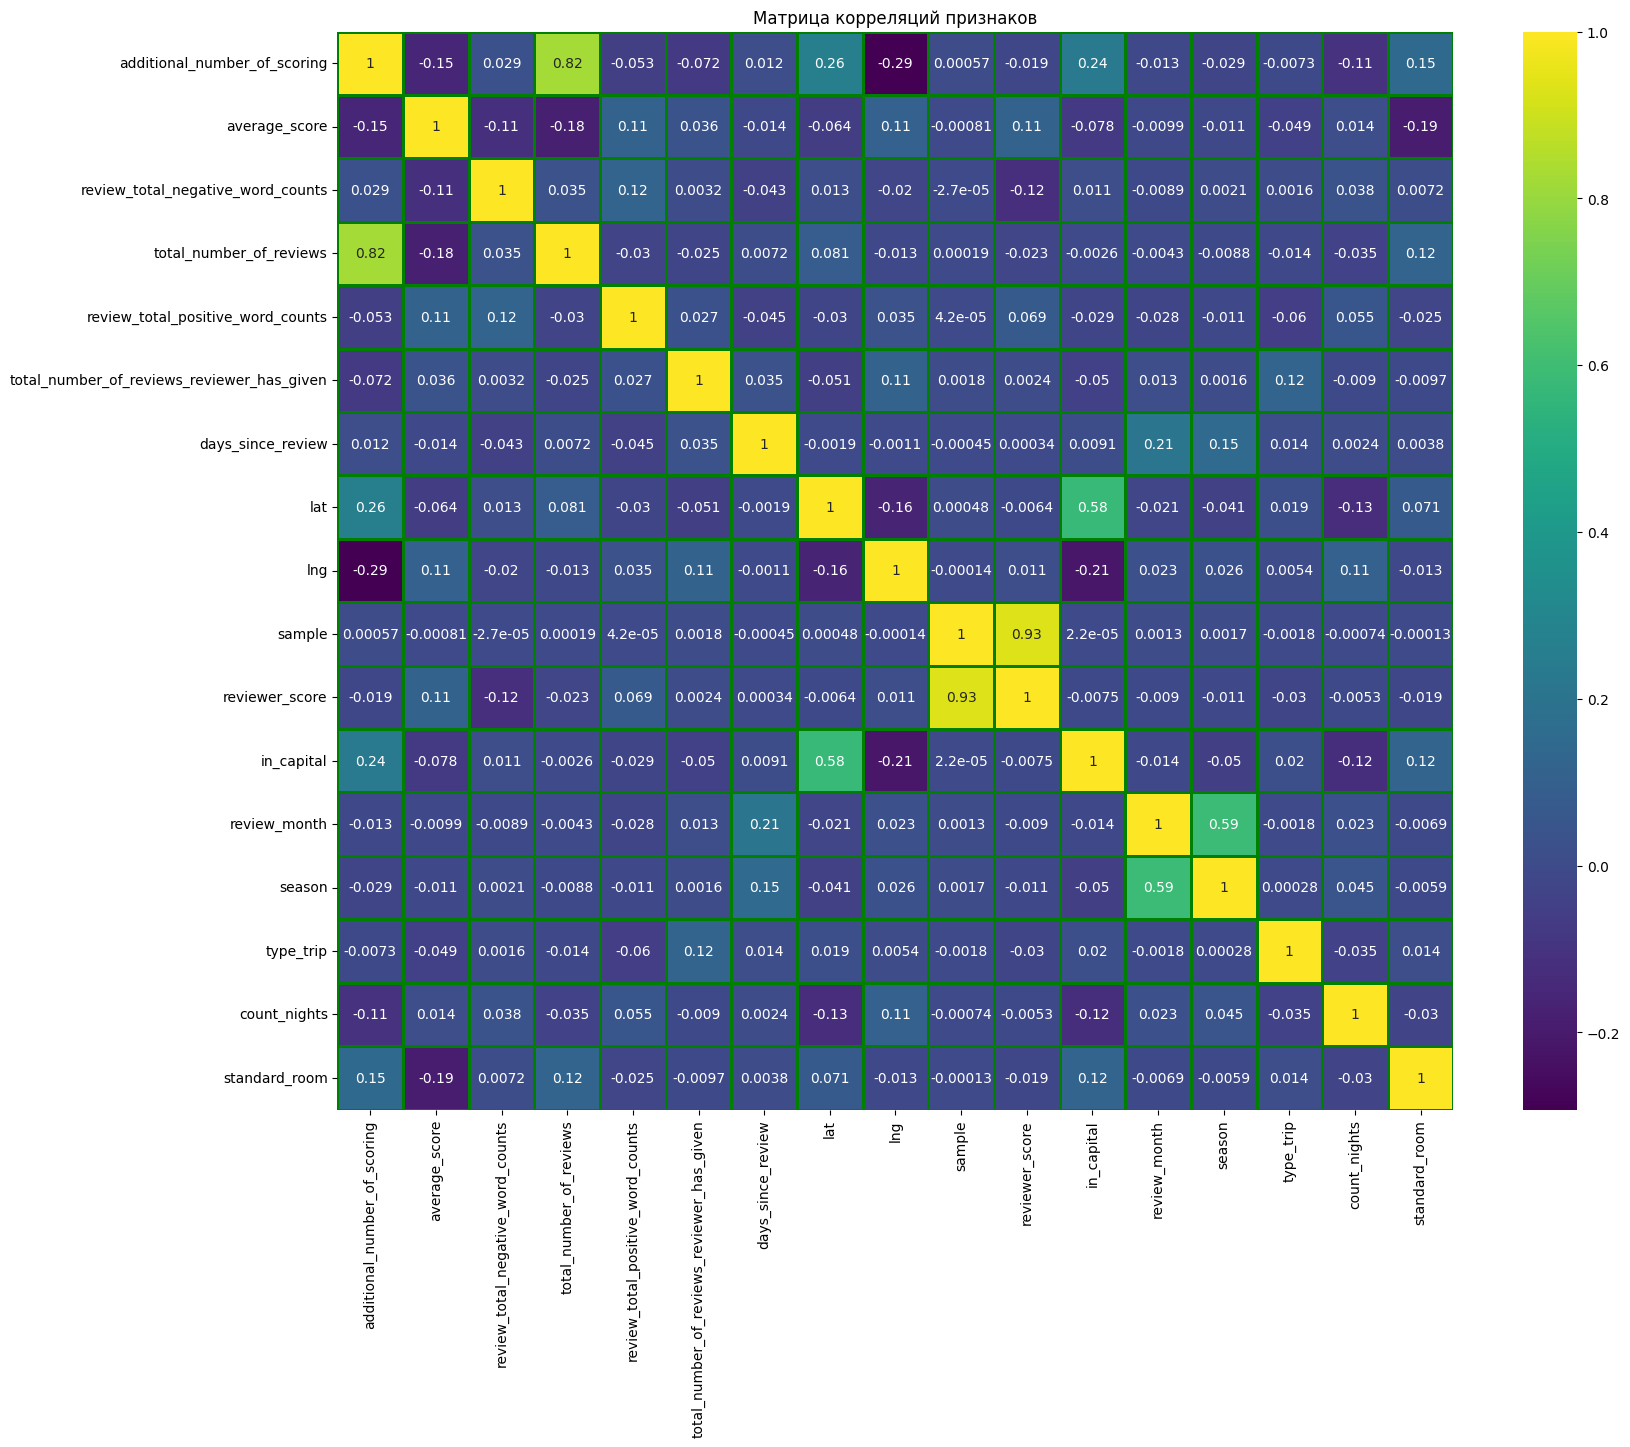

In [ ]:
col_list = data.columns[:17] # Список из 16 первых признаков
# Построим матрицу кодделяции по отобранным признакам
fig = plt.figure(figsize=(18, 14))
sns.heatmap(data[col_list].corr(), annot=True, fmt='.2g', cmap='viridis', linewidths=2, linecolor='green')
plt.title('Матрица корреляций признаков');

Признаки "additional_number_of_scoring" и "total_number_of_reviews" показывают высокую положительную корреляцию, поэтому удалим первый.

In [ ]:
data = data.drop('additional_number_of_scoring', axis=1)

In [ ]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [ ]:
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
print(X_train.shape, y_train.shape)

(309442, 58) (309442,)


In [ ]:
# Очистим обучающую выборку от выбросов
# ищем выбросы в обучающей выборке
iso = IsolationForest(contamination=0.2)
y_predicted = iso.fit_predict(X_train)

# выберем все строки, которые не являются выбросами
mask = y_predicted != -1
X_train, y_train = X_train[mask], y_train[mask]

print(X_train.shape, y_train.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


(247553, 58) (247553,)


### Random Forest

Random Forest является самым распространённым ансамблем типа бэггинг, в ходе которого параллельно обучается множество одинаковых моделей.

Выборка в этой модели выбирается посредством бутстрапа. Далее каждое решающее дерево обучается на случайной подвыборке из признакового пространства. Иными словами, случайный лес содержит в себе две случайности: случайная выборка для обучения и случайное множество признаков.

После обучения отдельные решающие деревья объединяются в ансамбль. Для задачи регрессии ансамблирование происходит посредством усреднения результата предсказания каждой базовой модели.

In [ ]:
# Создаём модель
model = ensemble.RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
# Обучаем модель на тестовом наборе данных
%time model.fit(X_train, y_train)
# Предсказанные значения для тренировочной и тестовой выборки
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


CPU times: user 5min 56s, sys: 1.34 s, total: 5min 58s
Wall time: 3min 29s


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    6.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.0s finished


In [ ]:
# Напишем функцию, которая создает словарь из значений метрик
def get_dict_metrics(y_train, y_train_predict, y_test, y_test_predict):
    dict_metrics = {
                'MAE score Train' : round(metrics.mean_absolute_error(y_train, y_train_predict), 2),
                'MAE score Test' : round(metrics.mean_absolute_error(y_test, y_test_predict), 2),
                'RMSE score Train' : round(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict)), 2),
                'RMSE score Test' : round(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)), 2),
                'MAPE score Train' : round(metrics.mean_absolute_percentage_error(y_train, y_train_predict) * 100, 2),
                'MAPE score Test' : round(metrics.mean_absolute_percentage_error(y_test, y_test_predict) * 100, 2),
                'R^2 score Train' : round(metrics.r2_score(y_train, y_train_predict), 2),
                'R^2 score Test' : round(metrics.r2_score(y_test, y_test_predict), 2)
                }
    return dict_metrics
dict_random_forest = get_dict_metrics(y_train, y_train_predict, y_test, y_test_predict)
dict_random_forest

{'MAE score Train': 0.33,
 'MAE score Test': 0.92,
 'RMSE score Train': 0.45,
 'RMSE score Test': 1.24,
 'MAPE score Train': 4.66,
 'MAPE score Test': 13.34,
 'R^2 score Train': 0.92,
 'R^2 score Test': 0.43}

Для оценки качества модели рассмотрим четыре метрики.
+ MAE (средняя абсолютная ошибка): это число показывает, насколько в среднем наша модель ошибается.

$MAE = \frac{\sum_{i=1}^{n}\left | y_{i} - \hat{y_{i}} \right |}{n}$

+ RMSE (корень из средней квадратичной ошибки): измеряет совокупную точность модели. Возведение в квадрат разницы значений позволяет лучше видеть различия в работе разных моделей, что позволяет их сравнивать.

$RMSE = \sqrt{MSE} = \sqrt{\frac{\sum_{i=1}^{n}(y_{i} - \hat{y_{i}})^{2}}{n}}$

+ MAPE (средняя абсолютная ошибка в процентах): показывает, на сколько процентов в среднем наше предсказание отклоняется от реального значения.

$MAPE = \sum_{i=1}^{n} \frac{\left | y_{i} - \hat{y_{i}} \right |}{\left | y_{i} \right |} \frac{100\%}{n}$

+ $R^{2}$ (коэффициент детерминации): показывает, насколько наша модель лучше, чем если бы все предсказания были средним по правильным ответам. Измеряет долю дисперсии в данных, объясняемую моделью. Метрика полезна для того, чтобы определить насколько хорошо модель подогнана к данным.

$R^{2} = 1 - \frac{MSE}{MSE_{mean}}$

Обучение модели на тренировочной и тестовой выборках показывают большой разброс в значениях внутри метрик. Разброс (variance) — это вариативность ошибки, то, насколько ошибка будет отличаться, если обучать модель на разных наборах данных. Математически это дисперсия (разброс) ответов модели. Таким образом, модель не смогла найти нужные закономерности и переобучилась. Особенно это хорошо видно на метрике $R^{2}$.

Попробуем решить проблему двумя способами:
1. Сократить количество признаков.
2. Подобрать другую модель.


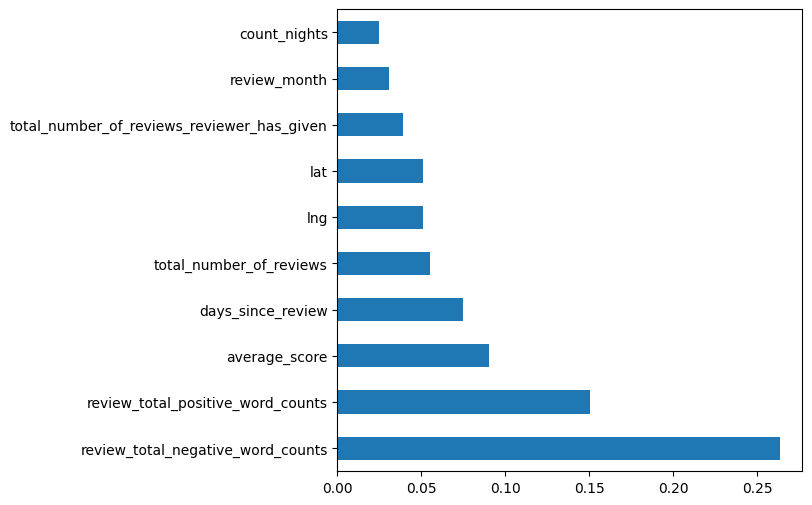

In [ ]:
# Построим график значимых признаков
plt.rcParams['figure.figsize'] = (6, 6)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Попробуем решить проблему переобучения модели методом отбора наиболее значимых признаков. Рассмотрим 2 варианта: тест ANOVA и корреляцию Пирсона

In [ ]:
# Отберем 15 признаков ANOVA тестом
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)

features_ANOVA = selector.get_feature_names_out()
print('Признаки, отобранные тестом ANOVA:', features_ANOVA)

Признаки, отобранные тестом ANOVA: ['average_score' 'review_total_negative_word_counts'
 'review_total_positive_word_counts'
 'total_number_of_reviews_reviewer_has_given' 'type_trip'
 'reviewer_nationality_Other'
 'reviewer_nationality_United States of America' 'negative_review_Room'
 'negative_review_Not negative' 'negative_review_Staff'
 'positive_review_Staff' 'positive_review_Not positive'
 'positive_review_Service' 'positive_review_Location'
 'guest_count_Solo traveler']


In [ ]:
# Обучим на них модель
model_anova = ensemble.RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
# Обучаем модель на тестовом наборе данных
%time model_anova.fit(X_train[features_ANOVA], y_train)
# Предсказанные значения для тренировочной и тестовой выборки
y_train_predict = model_anova.predict(X_train[features_ANOVA])
y_test_predict = model_anova.predict(X_test[features_ANOVA])
# Выведем значение метрик
model_rf_anova = get_dict_metrics(y_train, y_train_predict, y_test, y_test_predict)
model_rf_anova

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   53.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


CPU times: user 1min 28s, sys: 693 ms, total: 1min 28s
Wall time: 53.6 s


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.9s finished


{'MAE score Train': 0.39,
 'MAE score Test': 0.96,
 'RMSE score Train': 0.55,
 'RMSE score Test': 1.29,
 'MAPE score Train': 5.41,
 'MAPE score Test': 13.79,
 'R^2 score Train': 0.88,
 'R^2 score Test': 0.38}

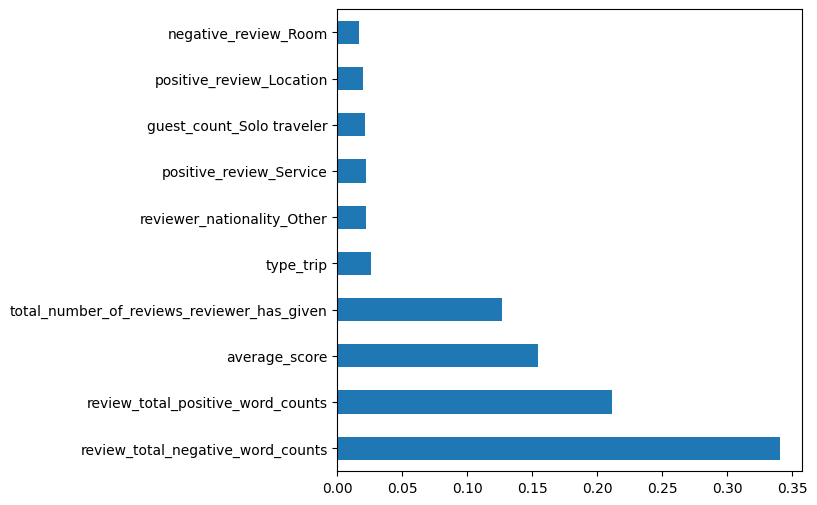

In [ ]:
plt.rcParams['figure.figsize'] = (6,6)
feat_importances = pd.Series(model_anova.feature_importances_, index=X[features_ANOVA].columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
# Отберем 15 признаков корреляцией Пирсона
selector = SelectKBest(f_regression, k=15)
selector.fit(X_train, y_train)

features_corr = selector.get_feature_names_out()
print('Признаки, отобранные тестом корреляции Пирсона:', features_corr)

Признаки, отобранные тестом корреляции Пирсона: ['average_score' 'review_total_negative_word_counts'
 'review_total_positive_word_counts' 'type_trip'
 'reviewer_nationality_Other'
 'reviewer_nationality_United States of America' 'negative_review_Service'
 'negative_review_Room' 'negative_review_Not negative'
 'negative_review_Staff' 'positive_review_Staff'
 'positive_review_Not positive' 'positive_review_Location'
 'country_United Kingdom' 'guest_count_Solo traveler']


In [ ]:
# Обучим на них модель
model_corr = ensemble.RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
# Обучаем модель на тестовом наборе данных
%time model_corr.fit(X_train[features_corr], y_train)
# Предсказанные значения для тренировочной и тестовой выборки
y_train_predict = model_anova.predict(X_train[features_ANOVA])
y_test_predict = model_anova.predict(X_test[features_ANOVA])
# Выведем значение метрик
model_rf_corr = get_dict_metrics(y_train, y_train_predict, y_test, y_test_predict)
model_rf_corr

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   44.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


CPU times: user 1min 14s, sys: 642 ms, total: 1min 15s
Wall time: 45 s


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    5.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.8s finished


{'MAE score Train': 0.39,
 'MAE score Test': 0.96,
 'RMSE score Train': 0.55,
 'RMSE score Test': 1.29,
 'MAPE score Train': 5.41,
 'MAPE score Test': 13.79,
 'R^2 score Train': 0.88,
 'R^2 score Test': 0.38}

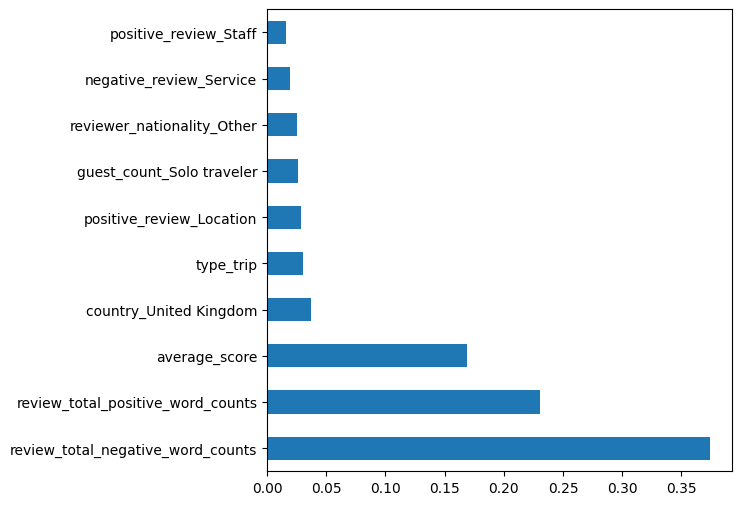

In [ ]:
plt.rcParams['figure.figsize'] = (6,6)
feat_importances = pd.Series(model_corr.feature_importances_, index=X[features_corr].columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
# Создадим объекты Series из словарей
metrics_RF = pd.Series(dict_random_forest)
metrics_anova = pd.Series(model_rf_anova)
metrics_corr = pd.Series(model_rf_corr)
# Объединим их в DataFrame, сбросим индексы, переименуем признаки
metrics_df = pd.concat([metrics_RF, metrics_anova, metrics_corr], axis=1).reset_index().rename(columns={'index' : 'Metric', 0 : 'Random forest', 1 : 'RF_anova', 2 : 'RF_corr'})
metrics_df

,Metric,Random forest,RF_anova,RF_corr
0,MAE score Train,0.33,0.39,0.39
1,MAE score Test,0.92,0.96,0.96
2,RMSE score Train,0.45,0.55,0.55
3,RMSE score Test,1.24,1.29,1.29
4,MAPE score Train,4.66,5.41,5.41
5,MAPE score Test,13.34,13.79,13.79
6,R^2 score Train,0.92,0.88,0.88
7,R^2 score Test,0.43,0.38,0.38


Сокращение признаков для обучения в данном случае не привело к улучшению показателей метрик. Попробуем обучить другую модель.

### Gradient boosting

Бустинг (boosting) — это алгоритм построения ансамбля, основанный на последовательном построении слабых моделей, причём каждая новая модель пытается уменьшить ошибку предыдущей. После того как все модели обучены, они объединяются в композицию.

В отличие от бэггинга, бустинг обучается на одном и том же наборе данных, без генерации дополнительных выборок. Однако в процессе обучения меняются  веса наблюдений. Если слабая модель допустила ошибку на каких-то примерах, то вес этих примеров увеличивается и на них концентрируется следующая за ней модель.

Поскольку основная цель бустинга — уменьшение смещения, в качестве базовых моделей часто выбирают алгоритмы с высоким смещением и небольшим разбросом, например короткие деревья решений. У каждого из таких деревьев слабая предсказательная способность, но если их объединить, мы получим очень мощную модель.

Таким образом, построим модель основанную на деревьях решений, в таком же количестве n_estimators=100, и с небольшой глубиной max_depth=3. Для предотвращения переобучения увеличим темп обучения learning_rate=0.6.

In [240]:
# Создаем модель градиентного бустинга
gb = GradientBoostingRegressor(
    loss='squared_error', #функция потерь
    learning_rate=0.6, #темп обучения
    n_estimators=100, #число деревьев
    max_depth=3, #максимальная глубина дерева
    random_state=RANDOM_SEED, #генератор случайных чисел
)
# Обучаем модель
%time gb.fit(X_train, y_train)
y_train_predict = gb.predict(X_train)
y_test_predict = gb.predict(X_test)


CPU times: user 1min 1s, sys: 55.9 ms, total: 1min 1s
Wall time: 1min 3s


In [241]:
model_gb = get_dict_metrics(y_train, y_train_predict, y_test, y_test_predict)
model_gb

{'MAE score Train': 0.86,
 'MAE score Test': 0.92,
 'RMSE score Train': 1.16,
 'RMSE score Test': 1.25,
 'MAPE score Train': 12.24,
 'MAPE score Test': 13.26,
 'R^2 score Train': 0.46,
 'R^2 score Test': 0.41}

In [242]:
metrics_df['Gradient boosting'] = model_gb.values()
metrics_df

,Metric,Random forest,RF_anova,RF_corr,Gradient boosting
0,MAE score Train,0.33,0.39,0.39,0.86
1,MAE score Test,0.92,0.96,0.96,0.92
2,RMSE score Train,0.45,0.55,0.55,1.16
3,RMSE score Test,1.24,1.29,1.29,1.25
4,MAPE score Train,4.66,5.41,5.41,12.24
5,MAPE score Test,13.34,13.79,13.79,13.26
6,R^2 score Train,0.92,0.88,0.88,0.46
7,R^2 score Test,0.43,0.38,0.38,0.41


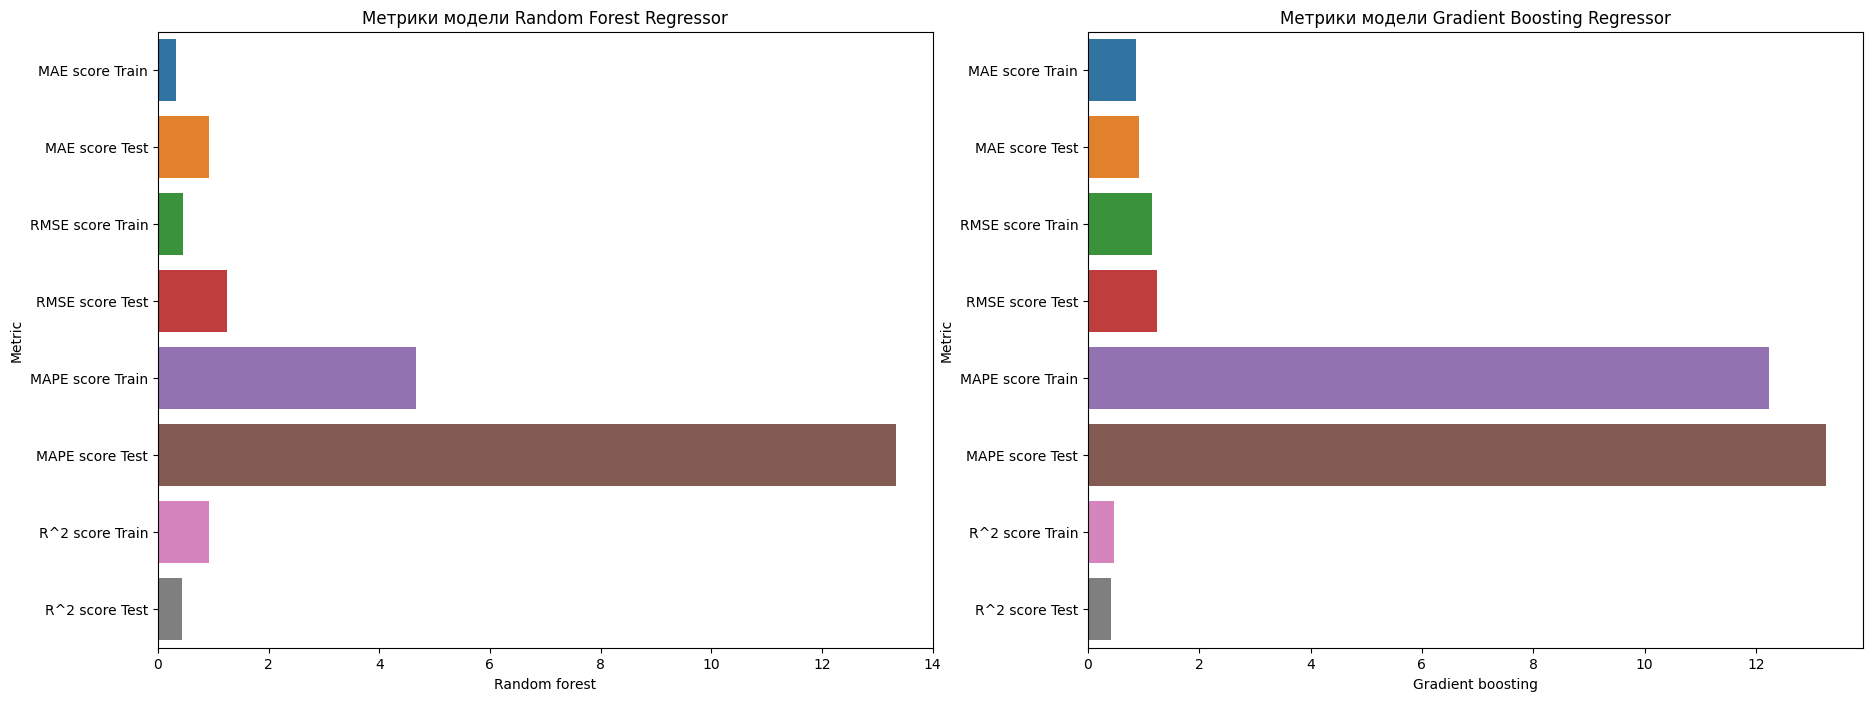

In [243]:
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
bar1 = sns.barplot(metrics_df,
                   x='Random forest',
                   y='Metric',
                   ax=axes[0])
bar2 = sns.barplot(metrics_df,
                   x='Gradient boosting',
                   y='Metric',
                   ax=axes[1])
bar1.set_title('Метрики модели Random Forest Regressor');
bar2.set_title('Метрики модели Gradient Boosting Regressor');
plt.show();


Разброс значений метрик тренировочной и тестовой выборок значительно сократился, что может говорить о снижении переобучения. Однако, показатель метрики $R^{2}$ не достигает 0.5.

Поэтому возможно продолжение работы над улучшением качества модели за счет повторного преобразования признаков и подбора гиперпараметров.